In [ ]:
import torch
import torch.tensor as tensor
import torch.nn as nn
import torch.nn.functional as tnf
import sklearn.datasets
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from itertools import chain
from tqdm import tqdm, trange
import sys
#sys.path.append('/home/lakshman/kitchensink/TestCSVAE/')
#from DataGen import *

### KL Divergence of Two Gaussians

---
ToDo: Double check the gaussians and sigma verification

$ -D_{KL}\left[q_\phi(w|(x,y))||p_\gamma(w|y)\right]$

$ q_\phi(w|(x,y)) = \mathcal{N}(w|\mu_\phi(x,y), \sigma_\phi(x,y))$

$ p_\gamma(w|y) = \mathcal{N}(\mu_1,\sigma_1) $

$ -D_{KL}\left[\mathrm{log}\frac{q_\phi(w|(x,y))}{p_\gamma(w|y)}\right] $
$ = \int p_\gamma(w|y) \mathrm{log} \left [ \frac{q_\phi(w|x,y)}{p_\gamma(w|y)} \right]dw $

$ = \int \left[\mathrm{log} \frac{1}{\sqrt{2\pi\sigma_\phi^2}}e^{\frac{-(x-\mu_\phi)^2}{2\sigma_\phi^2}} - \frac{1}{\sqrt{2\pi\sigma_\gamma^2}}e^{\frac{-(x-\mu_\gamma)^2}{2\gamma_\phi^2}}\right] * p_\gamma(w|y) dw$

$= \int \left[{-\frac{(x-\mu_\phi)^2}{2\sigma_\phi^2}} - 0.5 * \mathrm{log}{(2\pi\sigma_\phi^2)} + {\frac{(x-\mu_\gamma)^2}{2\sigma_\gamma^2}} + 0.5 * \mathrm{log}{(2\pi\sigma_\gamma^2)} \right] * p_\gamma(w|y) dw$

In $ \mathrm{log}{(2\pi\sigma^2)}$ the constants get zeroed out and remain with $\mathrm{log}(\sigma)$

The integral on the variable x should turn to expectation.

$ = -0.5 * \left[\mathrm{E_1} \left[ \frac{(x-\mu_\phi)^2}{\sigma_\phi^2} \right] - \mathrm{E_2} \left[ \frac{(x-\mu_\gamma)^2}{\sigma_\gamma^2} \right] \right] - 0.5 * \mathrm{log}\frac{\sigma_\phi}{\sigma_\gamma} $

The expectation of $(x-\sigma_\gamma)^2 = \sigma_\gamma^2$ therefore $E_2$ becomes 1.

$ = 0.5 - 0.5 * \mathrm{log}\sigma_\phi + 0.5 * \mathrm{log}\sigma_\gamma - 0.5 * \sigma_\phi^{-2} \left[ \mathrm{E_1}{(x-\mu_\phi)^2}\right] $

$ = 0.5 - 0.5 * \mathrm{log}\sigma_\phi + 0.5 * \mathrm{log}\mu_\gamma - 0.5 * \mu_\phi^{-2} \left[ \mathrm{E_1}{(x-\mu_\gamma + \mu_\gamma -\mu_\phi)^2}\right] $


$ = 0.5 - 0.5 * \mathrm{log}\sigma_\phi + 0.5 * \mathrm{log}\sigma_\gamma - 0.5 * \sigma_\phi^{-2} \left[ \mathrm{E_1} \left[{(x-\mu_\gamma)^2 + 2 * (x-\mu_\gamma) * (\mu_\gamma - \mu_\phi) + (\mu_\gamma - \mu_\phi)^2} \right]\right] $

Expectation of $(x-\mu_\gamma)^2$ is $\sigma_\gamma^2$

$ = 0.5 - 0.5 * \mathrm{log}\sigma_\phi + 0.5 * \mathrm{log}\sigma_\gamma - 0.5 * \sigma_\phi^{-2} \left[ \mathrm{E_1} \left[{(x-\mu_\gamma)^2 + 2 * (x-\mu_\gamma) * (\mu_\gamma - \mu_\phi) + (\mu_\gamma - \mu_\phi)^2} \right]\right] $

$= 0.5 - 0.5 * \mathrm{log}\sigma_\phi + 0.5 * \mathrm{log}\sigma_\gamma - 0.5 * \sigma_\phi^{-2} \left[ {\sigma_\gamma^2 + 2 * 0 * (\mu_\gamma - \mu_\phi) + (\mu_\gamma - \mu_\phi)^2} \right]$

### Gaussian MLP Setup
---
$q_{\phi_1}(z|x) = \mathcal{N}(z|\mu_{\phi_1}(x), \sigma_{\phi_1}(x))$

$q_{\phi_2}(w|x,y) = \mathcal{N}(w|\mu_{\phi_2}(x,y), \sigma_{\phi_2}(x,y))$

$p_\theta(x|w,z) = \mathcal{N}(\mu_\theta,(w,z), \sigma_\theta(w,z))$

$ p(w_i| y_i = 1) = \mathcal{N}(\mu_1, \sigma_1) $

$ p(w_i| y_i = 0) = \mathcal{N}(\mu_2, \sigma_2) $

$q_\delta = Cat(y|\pi_\delta(z)) $

$\mu_1 = (0,0) \space \sigma_1 = (0.1, 0.1) $

$\mu_2 = (3, 3) \space \sigma_2 = (1, 1) $




In [ ]:
def generate_data(generator, y_name, decider, n = 100):
  '''This function provides a general framework to generate artificial datasets.
  The user defines a 'generator' and 'decider' which generate an individual
  data point and then decide if the response for this variable is positive or
  negative (0/1). Generator should return a dictionary of individual attributes,
  and decider should accept the individual dictionary as a parameter and return
  a 0/1 based on the individual's attributes.
  '''
  data = []

  for i1 in range(n):
    datum = generator()

    datum[y_name] = decider(datum)

    data.append(datum)

  return pd.DataFrame(data)


AGE_MIN = 20
AGE_MAX = 80

SEX = ['male', 'female']

# https://grants.nih.gov/grants/guide/notice-files/not-od-15-089.html
RACE = ['American Indian or Alaska Native',
         'Asian',
         'Black or African American',
         'Hispanic or Latino',
         'Native Hawaiian or Other Pacific Islander',
         'White']

# Generalize credit score to the five ranges
# 300-579: Poor.
# 580-669: Fair.
# 670-739: Good.
# 740-799: Very good.
# 800-850: Excellent.
CREDIT_SCORE = ['poor', 'fair', 'good', 'very good', 'excellent']

# Generalize education to three levels, much more complex in real world
EDUCATION = ['high school', 'college', 'graduate school']

# Generalize salary to three buckets
SALARY = ['low', 'medium', 'high']

# Generalize loan amnt to three buckets
LOAN_AMOUNT = ['low', 'medium', 'high']

def insurance_generator():
  '''Generate an individual included in the insurance dataset.'''
  return {
      'age': np.random.randint(AGE_MIN, AGE_MAX)/100.0,
      'sex': np.random.choice(SEX),
      'race': np.random.choice(RACE),
      'credit_score': np.random.choice(CREDIT_SCORE),
      'education': np.random.choice(EDUCATION),
      'salary': np.random.choice(range(100, 20000))/10000.0,
      'debt': np.random.choice(range(0, 15000))/10000.0,
      'married': round(np.random.random()), # 0 or 1
      'loan_amount': np.random.choice(LOAN_AMOUNT)
  }

def random_decider(individual):
    # Totally random, 50% chance
    d2i = (individual['debt']/individual['salary'])
    if d2i >= 1.0 or individual['credit_score'] == 'poor' or (individual['education'] == 'high school' and individual['salary'] <= 0.1):
        return 0
    if individual['age'] >= 0.67:
        return np.random.choice([0,1], p=[0.7, 0.3])
    return 1


In [ ]:
 #https://github.com/qq456cvb/CSVAE/blob/master/model.py

class EncoderZ(nn.Module):
    def __init__(self, dim_in, dim_out):
        super().__init__()
        self.dim_out = dim_out
        self.fcs = nn.Sequential(
            nn.Linear(dim_in, 64), #input layer
            nn.ReLU(),          # activation
            nn.Linear(64, 64),  # hidden
            nn.ReLU(),
            nn.Linear(64, 64),  # hidden
            nn.ReLU(),
            nn.Linear(64, 2 * dim_out)) # for mu and sigma for each dimension

    def forward(self, x):
        out = self.fcs(x)
        mu = out[:, :self.dim_out]
        logvar = out[:, self.dim_out:]
        # now get the samples on mu and logvar
        std = torch.exp(0.5 * logvar)
        samples = torch.randn_like(mu) * std + mu
        return mu, logvar, samples

class EncoderW(nn.Module):
    def __init__(self, dim_in, dim_out):
        super().__init__()
        self.dim_out = dim_out
        self.fcs = nn.Sequential(
            nn.Linear(dim_in, 64), #input layer
            nn.ReLU(),          # activation
            nn.Linear(64, 64),  # hidden
            nn.ReLU(),
            nn.Linear(64, 64),  # hidden
            nn.ReLU(),
            nn.Linear(64, 2 * dim_out))
    
    def forward(self, x, y):
        out = self.fcs(torch.cat((x, y), dim=-1))
        mu = out[:, :self.dim_out]
        logvar = out[:, self.dim_out:]
        std = torch.exp(0.5 * logvar)
        samples = torch.randn_like(mu) * std + mu
        return mu, logvar, samples

class DecoderX(nn.Module):
    def __init__(self, dim_in, dim_out):
        super().__init__()
        self.dim_out = dim_out
        self.fcs = nn.Sequential(
            nn.Linear(dim_in, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 2 * dim_out)
        )

    def forward(self, w, z):
        out = self.fcs(torch.cat((w, z), dim=-1))
        mu = out[:, :self.dim_out]
        logvar = out[:, self.dim_out:]  # decorrelated gaussian
        sample = torch.randn_like(mu) * torch.exp(0.5 * logvar) + mu
        return mu, logvar, sample


In [ ]:
class CSVAE:
    def __init__(self, minibatch=1, xdim=3, ydim=1, mu=[0.0,3.0], sigma=[0.01, 1.0]):
        self.n_class = 2
        # Dimensions setup
        self.xdim_in = xdim
        self.xdim_out = xdim
        self.ydim_in = 1
        self.ydim_out = ydim
        self.zdim_in = self.xdim_out
        self.zdim_out = 2
        self.wdim_in = self.xdim_in + self.ydim_in
        self.wdim_out = 2
        
        # constants
        self.mini_batch = minibatch
        self.mu1 = mu[0]
        self.sigma1 = sigma[0]
        self.mu2 = mu[1]
        self.sigma2 = sigma[1]
        
        self.zencoder = EncoderZ(self.xdim_in, self.zdim_out)
        self.wencoder = EncoderW(self.wdim_in, self.wdim_out)
        xwz_in = self.zdim_out + self.wdim_out
        
        # ToDo: trobleshoot the network below vs net defined in class xdecoder.
        self.xdecoder = nn.Sequential(
            nn.Linear(xwz_in, 64), #input layer
            nn.ReLU(), # activation
            nn.Linear(64, 64), # hidden
            nn.ReLU(),
            nn.Linear(64, 2 * self.xdim_in))
         
        self.yencoder = nn.Sequential(
            nn.Linear(self.zdim_out, 64), #input layer
            nn.ReLU(),          # activation
            nn.Linear(64, 64),  # hidden
            nn.ReLU(),
            nn.Linear(64, self.n_class),
            nn.Softmax(dim=-1)
        )
    
        self.xdecoder2 = DecoderX(4, 3)
        
    def dec_samples(self, mu, std):
        sample = torch.randn_like(mu) * std + mu
        return sample
    
    def KL2Gaussians(self, mu1, logvar1, mu2, logvar2):
        std1 = torch.exp(0.5 * logvar1)
        std2 = torch.exp(0.5 * logvar2)

        return torch.sum(torch.log(std2) - torch.log(std1) + 0.5 * (torch.exp(logvar1) + (mu1 - mu2) ** 2) / torch.exp(logvar2) - 0.5, dim=-1)
    
    def encodeCSVAE(self, xs, ys, num_epochs=10, learn_rate=1e-3, c1=20., c2=1000., c3=100., d1=0.2):
        optimizer1 = torch.optim.Adam(chain(self.xdecoder2.parameters(),
                                           self.wencoder.parameters(),
                                           self.zencoder.parameters()), lr = learn_rate)
        optimizer2 = torch.optim.Adam(chain(self.yencoder.parameters()), lr= learn_rate)
                
        # shuffle input data with mini batch using DataLoader
        traindata = torch.utils.data.DataLoader(list(zip(xs, ys)), shuffle=True, batch_size=self.mini_batch)
        
        with trange(num_epochs) as t:
            for i in t:
                t.set_description('Epoch %d' % i)
                for x, y in traindata:
                    mu_z, logvar_z, samples_z = self.zencoder(x)
                    mu_w, logvar_w, samples_w = self.wencoder(x, y.unsqueeze(-1).float())

                    #xout = self.xdecoder(torch.cat((samples_w, samples_z), dim=-1))
                    #mu_x = xout[:, :self.xdim_out]
                    #std_x = torch.exp(xout[:, self.xdim_out:]) # unused

                    mu_x, _, _ = self.xdecoder2(samples_w, samples_z)
                    
                    pred_y = self.yencoder(samples_z)

                    kl1_w = self.KL2Gaussians(mu_w, logvar_w, 
                                              torch.zeros_like(mu_w), torch.ones_like(logvar_w) * np.log(self.sigma1))
                    kl0_w = self.KL2Gaussians(mu_w, logvar_w, 
                                              torch.ones_like(mu_w) * self.mu2, torch.ones_like(logvar_w) * np.log(self.sigma2))

                    optimizer1.zero_grad()

                    #print("X shape: ", x.shape, "  ", mu_x.shape)
                    loss1 = (c1 * torch.sum((x - mu_x) ** 2, 1)
                        + 1. * torch.where(y == 1, kl1_w, kl0_w)
                        + d1 * self.KL2Gaussians(mu_z, logvar_z, torch.zeros_like(mu_z), torch.ones_like(logvar_z))
                        + c2 * torch.sum(pred_y * torch.log(pred_y), -1)).sum()

                    loss1.backward(retain_graph=True)

                    optimizer2.zero_grad()
                    loss2 = (c3 * torch.where(y == 1, -torch.log(pred_y[:, 1]), -torch.log(pred_y[:, 0]))).sum()
                    loss2.backward()

                    optimizer1.step()
                    optimizer2.step()

                    loss = loss1 + loss2
                t.set_postfix(loss=loss.item(), y_max=pred_y.max().item(), y_min=pred_y.min().item())
    
        return samples_z, samples_w
    
    def decodeCSVAE(self, xs, ys):
        with torch.no_grad():
            zs, _, _ = self.zencoder(xs)
            ws, _, _ = self.wencoder(xs, ys.unsqueeze(-1).float())
            #xsamples = self.decodeCSVAE_zw(zs, ws)
            xsamples,_,_ = self.xdecoder2(ws, zs)
        return xsamples

    def decodeCSVAE_zw(self, z, w):
        xout = self.xdecoder(torch.cat((w, z), dim=-1))
        mu_x = xout[:, :self.xdim_out]
        std_x = torch.exp(0.5 * xout[:, self.xdim_out:])
        xsamples = self.dec_samples(mu_x, std_x)
        
        #mu_x, _, xsamples = self.xdecoder2(samples_w, samples_z)
        
        return xsamples

XS Shape:  (10000, 3)
YS Sum:  4738 YS Shape:  (10000,) [0 0 1 ... 1 1 1]


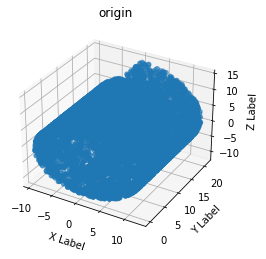

Epoch 0:   0%|          | 0/10 [00:00<?, ?it/s]

####### xs ys shape (10000, 3)      (10000,)


Epoch 9: 100%|██████████| 10/10 [00:04<00:00,  2.46it/s, loss=-7.97e+3, y_max=0.831, y_min=0.169] 


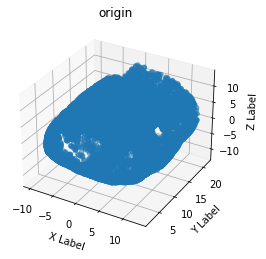

In [ ]:
csvae = CSVAE(minibatch=256, mu=[0.0,2.0], sigma=[0.01, 1.0])
xs, _ = sklearn.datasets.make_swiss_roll(10000)
xs = xs.astype(np.float32)
print("XS Shape: ", xs.shape)
ys = (xs[:, 1] < 10).astype(np.int32)
print("YS Sum: ", np.sum(ys), "YS Shape: ", ys.shape, ys)

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.scatter(xs[:, 0], xs[:, 1], xs[:, 2])
ax.set_title('origin')
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
plt.show()

print("####### xs ys shape", xs.shape, "    ", ys.shape)
zt, wt = csvae.encodeCSVAE(xs, ys, num_epochs=10)
samples = csvae.decodeCSVAE(torch.from_numpy(xs), torch.from_numpy(ys))
samples = samples.cpu().numpy()

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.scatter(samples[:, 0], samples[:, 1], samples[:, 2])
ax.set_title('origin')
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
plt.show()



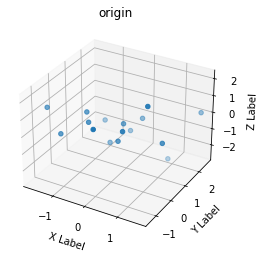

In [ ]:
with torch.no_grad():
    xt = csvae.decodeCSVAE_zw(zt, wt)
    xt = xt.cpu().numpy()
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.scatter(xt[:, 0], xt[:, 1], xt[:, 2])
ax.set_title('origin')
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
plt.show()

In [ ]:
loandata = generate_data(insurance_generator, 'loan_approved', random_decider, n = 7000)

xl = loandata[['age','salary','debt']]
yl = loandata['loan_approved']
xl = xl.astype(np.float32)
txl = (torch.tensor(xl.values))
tyl = torch.tensor(yl.values)

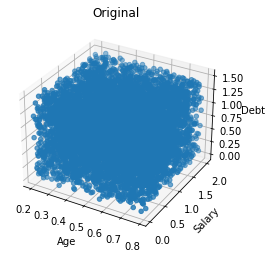

Epoch 0:   0%|          | 0/40 [00:00<?, ?it/s]

####### xs ys shape (7000, 3)      (7000,)


Epoch 39: 100%|██████████| 40/40 [00:19<00:00,  2.01it/s, loss=-1.92e+5, y_max=0.545, y_min=0.455]


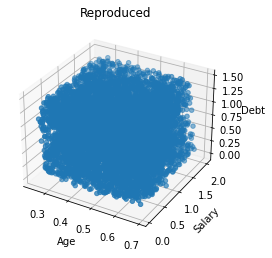

In [ ]:
# Set1: mu=[0.0, 4.7] sigma=[0.8,1.0], c1=240.,c2=5050,c3=75.,d1=0.9
# Set2: mu=[0.0, 4.7] sigma=[0.8,1.0], c1=240.,c2=5050,c3=75.,d1=0.0025 (better)

csvae = CSVAE(minibatch=124,mu=[0.0, 4.7], sigma=[0.8, 1.0])
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.scatter(xl['age'], xl['salary'], xl['debt'])
ax.set_title('Original')
ax.set_xlabel('Age')
ax.set_ylabel('Salary')
ax.set_zlabel('Debt')
plt.show()

print("####### xs ys shape", xl.shape, "    ", yl.shape)

zt, wt = csvae.encodeCSVAE(txl, tyl, num_epochs=40, c1=240., c2=5050., c3=75.,d1=0.0025)
samples = csvae.decodeCSVAE((txl), (tyl))
samples = samples.cpu().numpy()

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.scatter(samples[:, 0], samples[:, 1], samples[:, 2])
ax.set_title('Reproduced')
ax.set_xlabel('Age')
ax.set_ylabel('Salary')
ax.set_zlabel('Debt')
plt.show()


rejects indx =  1
tensor([[0.6000, 0.2096, 0.8821]])   tensor([0])
Recreate samples with y=0 [[0.5453335  0.20168974 0.85420674]]
Predictive Counterfactual (y=1) [[0.53453815 0.27575964 0.8307554 ]]


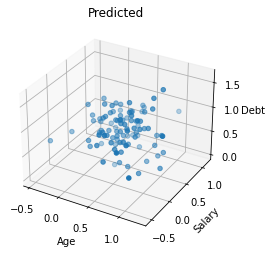

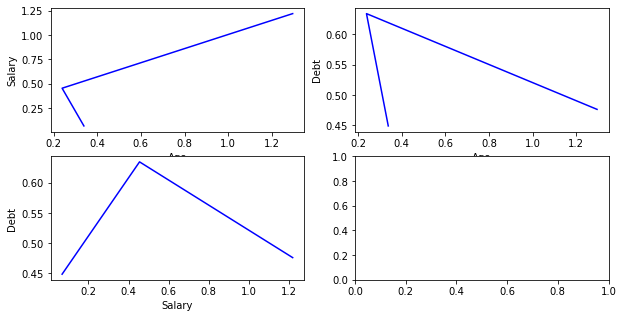

Average values of Counterfactuals:  [0.51208292 0.26425375 0.85370029]


In [ ]:
rejects = np.where(yl[:] == 0)
#print(np.array(xl.iloc[0]), "  ", yl[0])
#print(tyl)
print("rejects indx = ", rejects[0][0])
rejval_x = np.array(xl.iloc[rejects[0][0]])
crx = torch.tensor(rejval_x.reshape(1,-1))
cry = torch.tensor(np.array([yl[rejects[0][0]]]))
print(crx, " ", cry)
crp = csvae.decodeCSVAE((crx), (cry))
print("Recreate samples with y=0", crp.numpy())
cry = torch.tensor(np.array([1]))
crp = csvae.decodeCSVAE((crx), (cry))
predval = crp.numpy()
print("Predictive Counterfactual (y=1)", predval)

values = np.random.multivariate_normal(crp.numpy().flatten(), np.eye(3) * 0.1, size=100)

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.scatter(values[:, 0], values[:, 1], values[:, 2])
ax.set_title('Predicted')
ax.set_xlabel('Age')
ax.set_ylabel('Salary')
ax.set_zlabel('Debt')
plt.show()

fig, ax = plt.subplots(2, 2, figsize=(10, 5))
ax[0][0].plot(values[0], values[1], color='blue', label='Age vs Salary')
ax[0][0].set(xlabel='Age', ylabel='Salary')
ax[0][1].plot(values[0], values[2], color='blue', label='Age vs Debt')
ax[0][1].set(xlabel='Age', ylabel='Debt')
ax[1][0].plot(values[1], values[2], color='blue', label='Salary vs Debt')
ax[1][0].set(xlabel='Salary', ylabel='Debt')
plt.show()

print("Average values of Counterfactuals: ", values.mean(axis=0))
orig_prop = []
for i in rejects[0]:
    crx = torch.tensor(np.array(xl.iloc[i]).reshape(1,-1))
    cry = torch.tensor(np.array([1]))
    crp = csvae.decodeCSVAE((crx), (cry))
    predval = crp.numpy()

    orig_prop.append([xl.iloc[i].to_numpy(), predval.flatten()])


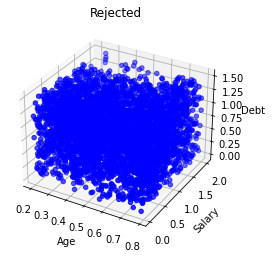

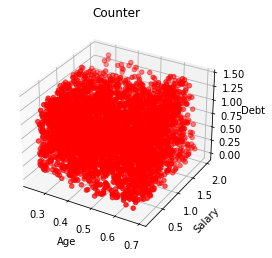

In [ ]:
orig_prop = np.array(orig_prop)

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.scatter(orig_prop[:,0][:,0], orig_prop[:,0][:,1], orig_prop[:,0][:,2], color='blue')
#ax.scatter(orig_prop[:,1][:,0], orig_prop[:,1][:,1], orig_prop[:,1][:,2], color='red')
ax.set_title('Rejected')
ax.set_xlabel('Age')
ax.set_ylabel('Salary')
ax.set_zlabel('Debt')
plt.show()

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection='3d')
#ax.scatter(orig_prop[:,0][:,0], orig_prop[:,0][:,1], orig_prop[:,0][:,2], color='blue')
ax.scatter(orig_prop[:,1][:,0], orig_prop[:,1][:,1], orig_prop[:,1][:,2], color='red')
ax.set_title('Counter')
ax.set_xlabel('Age')
ax.set_ylabel('Salary')
ax.set_zlabel('Debt')
plt.show()
